In [84]:
%run ./setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import numpy as np # linear algebra
import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
# from plotly.subplots import make_subplot
from geopy.geocoders import Nominatim
from skimage import io
# import ipywidgets as widgets
import re
from ipywidgets import interact, interact_manual
import folium
import time
from collections import defaultdict
import json
# helpful modules
from scipy.spatial.distance import euclidean, pdist, squareform
from datetime import datetime

<div style="font-family:'Trebuchet MS', 'Impact', sans-serif; 
            margin-bottom: 20px; letter-spacing: 6px; text-align:center;
            font-size: 200%;"><b>University of Toronto ECE2T2 Class Profile</b></div>

<div style="font-size: 16px;text-align:center;"><i>Number of Respondents: 52</i></div>
<!-- <div style="font-size: 16px;text-align:center;"><i>All Plots show data</i></div> -->

<p style="text-align:start;">Welcome to the University of Toronto ECE2T2 Class Profile -- Inspired by Waterloo Software Engineering 2021 Class Profile. 
We come here to give you all the deets, all the information on our graduating class: their passions, compassions, and the future they have built in their times at UofT.
   
Let's find out about who these 52 people of University of Toronto ECE2T2 are, and where they be at!</p>

In [86]:
df = pd.read_csv("Electrical_and_Computer_Engineering_2023_-_Class_Profile_Survey_Submissions_2023-03-29.csv")

In [87]:
print(len(df))
df.head(5)

52


,Submission ID,Respondent ID,Submitted at,What program were you in first year?,What program are you in now?,What 2 areas did you specialize in?,What 2 areas did you specialize in? (Area 1: Photonics & Semiconductor Physics),What 2 areas did you specialize in? (Area 2: Electromagnetics & Energy Systems),What 2 areas did you specialize in? (Area 3: Digital & Analog Electronics),"What 2 areas did you specialize in? (Area 4: Systems Control, Communications & Signal Processing)",...,Which of the following have you done during university? (Kissed someone romantically),Which of the following have you done during university? (Been in a committed relationship),Which of the following have you done during university? (Been in a long distance relationship),Which of the following have you done during university? (Had 'friends with benefits'),Which of the following have you done during university? (Used a dating app),List the recreational controlled substances you have used during university,Untitled long answer field (1),Untitled long answer field (2),Untitled long answer field (3),How many sexual partners have you had
0,qaRxpG,VpyqOy,2023-02-21 01:01:21,Computer,Computer,"Area 5: Computer Hardware & Computer Networks,...",False,False,False,False,...,False,False,False,False,True,NaN,Interesting to see myself - as a person who kn...,Maybe not doing enough design teams and not sp...,Hope for the best for everyone 🙂,0.0
1,07e206,J1YGy4,2023-02-21 01:10:02,Electrical,Electrical,"Area 6: Computer Software, Area 4: Systems Con...",False,False,False,True,...,NaN,NaN,NaN,NaN,NaN,Cannabis,The pandemic allowed me to realize I did not h...,I wish I had learned to focus on my own person...,Do not lose the person that you are in spite o...,0.0
2,E5xj2L,kbxgVM,2023-02-21 01:18:09,TrackOne,Computer,"Area 5: Computer Hardware & Computer Networks,...",False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,Cannabis,NaN,NaN,Live long and prosper,0.0
3,PDOjb0,9N5avV,2023-02-21 01:53:57,TrackOne,Electrical,"Area 1: Photonics & Semiconductor Physics, Are...",True,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,Celebrating my birthday with my U of T friends:),Not playing intramurals and going to more soci...,Find joy in simple things:),NaN
4,9XQGoK,6D59QJ,2023-02-21 01:55:39,TrackOne,Computer,"Area 6: Computer Software, Area 5: Computer Ha...",False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning



In [88]:
## Write out columns to a text file for analysis
with open("all_columns.txt", mode="w", encoding="utf-8") as f:
    f.write("\n".join(df.columns))

In [89]:
# Modify these column names, if they still exist
if {"Untitled long answer field (1)", "Untitled long answer field (2)", "Untitled long answer field (3)"}.issubset(df.columns):
  df.rename(columns={
                      "Untitled long answer field (1)" : "1. Share a story, happy or sad, from your time in ECE",
                      "Untitled long answer field (2)" : "2. What is something you regret over your time at UofT?",
                      "Untitled long answer field (3)" : "3. Give a piece of advice to your fellow ECE 2T2 - 2023 grads"
                    }, inplace=True)

  # Check column data has indeed been changed
  index = df.columns.str.contains("1. Share a story, happy or sad, from your time in ECE") | \
  df.columns.str.contains("2. What is something you regret over your time at UofT?") | \
  df.columns.str.contains("3. Give a piece of advice to your fellow ECE 2T2 - 2023 grads")

  indices = df.columns[index]
  assert len(indices) == 3

In [90]:
# Drop unnecessary article. Non-useful data.
# Proof that all data under this column are null
if "https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-ameri" + \
          "can-economic-class-system" in df.columns:
        assert df["https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-ameri"
                "can-economic-class-system"].isna().sum() == len(df)

        df.drop("https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system", 
                axis=1, inplace=True)

## Data Exploration

# Class Profile

## What Program Were You in First Year?

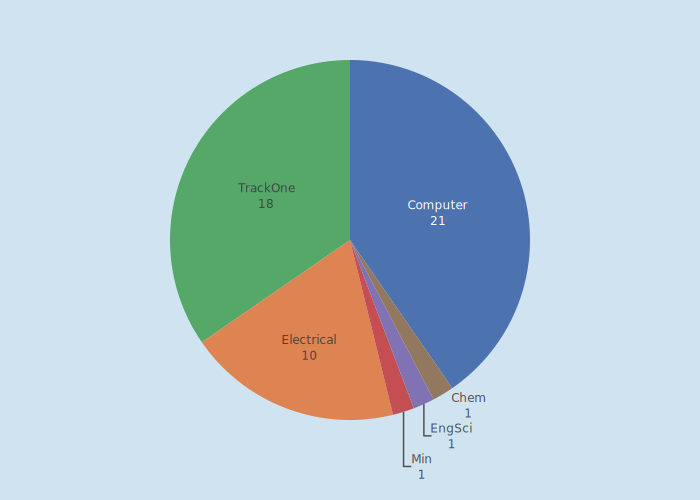

In [91]:
# TO-DO! Make trace subplots with this
fig = px.pie(df, names="What program were you in first year?", color="What program were you in first year?")
fig.update_traces(textinfo="label+value",
                  hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])
fig.update_layout(showlegend=False)
fig.show()

## What Program Are You in Now?

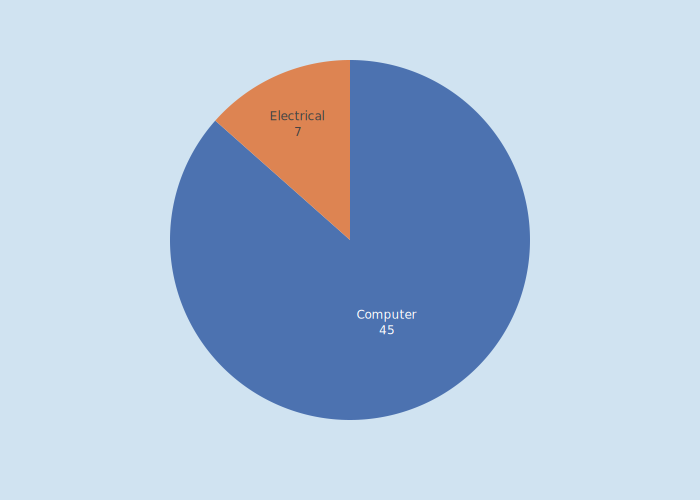

In [92]:
fig = px.pie(df, names="What program are you in now?", color="What program are you in now?")
fig.update_traces(textinfo="label+value",
                  hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])
fig.update_layout(showlegend=False)
fig.show()

## What 2 Areas Did You Specialize In?

In [93]:
# Sort specialized areas to remove duplicates. (Ex. Area 6 + Area 5 is equivalent to Area 5 + Area 6)
df["What 2 areas did you specialize in?"] = remove_redundancy(df["What 2 areas did you specialize in?"]) 

In [94]:
df_specialization = df.loc[:, ["What 2 areas did you specialize in?"]]
df_specialization.sort_values("What 2 areas did you specialize in?", ascending=False, inplace=True)

# hover text
areas_long_form = df_specialization["What 2 areas did you specialize in?"].str.split(", ").map(lambda x: "<br>".join(x)).tolist()

# Simplified areas
areas_simplified = df_specialization["What 2 areas did you specialize in?"].map(
    lambda word: " + ".join(re.findall('(Area.*?):', word))
)

df_specialization["What 2 areas did you specialize in?"] = areas_simplified




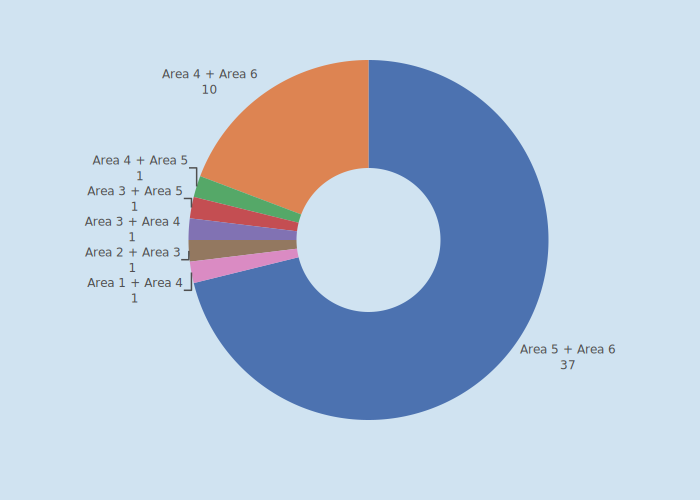

In [70]:
# df.groupby("What 2 areas did you specialize in?", as_index=False).count()[["What 2 areas did you specialize in?", "Submission ID"]]
fig = px.pie(df_specialization, names="What 2 areas did you specialize in?", color="What 2 areas did you specialize in?",
             hole=0.4)
fig.update_traces(textinfo="label+value",
                  hovertemplate="%{text}<br><i>Count:</i> %{value}<br> %{percent}",
                  hovertext=areas_long_form,
                  text=areas_simplified,
                  textposition="outside",
                )
# fig.update_layout(legend=dict(traceorder="reversed",
#                               yanchor="top", xanchor="center",
#                               orientation="h",
#                               x=0.5, y=-0.1),
#                               showlegend=True)
fig.show()

## Exchange Information

In [71]:
# data_checker(df["Have you participated in an exchange?"], check_unique=True)

In [72]:
df["Have you participated in an exchange?"].fillna("Did not say", inplace=True)

In [73]:
# data_checker(df["If yes, where did you do your exchange?"], check_unique=True)

In [74]:
assert(
    df.loc[(df["Have you participated in an exchange?"] == "no") & \
        df["If yes, where did you do your exchange?"].notna(), ["Have you participated in an exchange?", 
                                                                "If yes, where did you do your exchange?"]].shape[0] == 0
)

In [75]:
assert(
    df.loc[(df["Have you participated in an exchange?"] == "yes") & \
        df["If yes, where did you do your exchange?"].isna(), ["Have you participated in an exchange?", 
                                                                "If yes, where did you do your exchange?"]].shape[0] == 0
)

In [76]:
# data_checker(df["If you did not do an exchange, what were your reasons for not?"], check_unique=True)

In [77]:
df["If you did not do an exchange, what were your reasons for not?"].fillna("No answer", inplace=True)

In [78]:
assert(
    df.loc[(df["Have you participated in an exchange?"] == "yes") & \
        (df["If you did not do an exchange, what were your reasons for not?"] != "No answer"), :].shape[0] == 0
)

In [79]:
df_no_exchange_reasons = \
    process_multiple_choice_survey(df["If you did not do an exchange, what were your reasons for not?"], column="exchangeReasons")

In [80]:
df["No Exchange Reasons"] = df_no_exchange_reasons["exchangeReasons"]

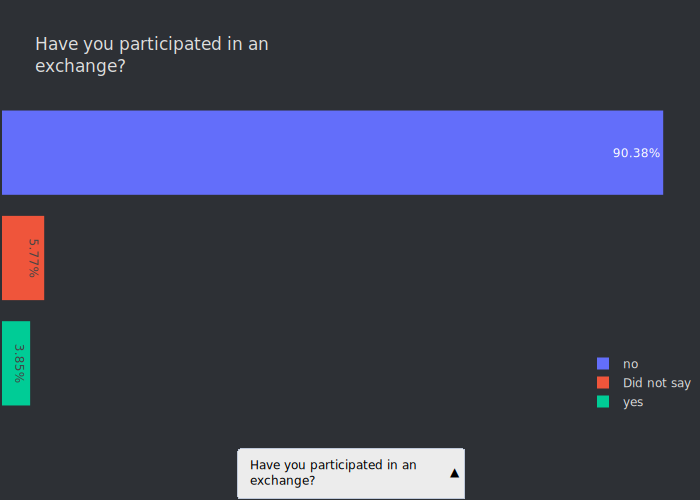

In [83]:
fig = create_figure_with_dropdown(df, 
                            options=["Have you participated in an exchange?",
                                     "If yes, where did you do your exchange?",
                                     "No Exchange Reasons"],
                            labels=break_text(["Have you participated in an exchange?",
                                     "If yes, where did you do your exchange? (Sample Size: 2)",
                                     "If you did not do an exchange, what were your reasons for not? (Sample Size: 47)"], char_limit=27),
                            showticklabels=[False, False, False],
                            sort_traces=True,
                            textposition="auto",
                            horizontal=True
    )
change_to_dark_mode_plotly(fig)
fig.update_xaxes(showticklabels=False)
fig.show()

## Other Profile Information (Gender, Sexual Orientation, Domestic/International, Ethnicities)

In [ ]:
# data_checker(df["Are you a domestic or international student?"], check_unique=True)

In [ ]:
# data_checker(df["What are your Ethnicities?"], check_unique=True)

In [ ]:
df["What are your Ethnicities?"].fillna("Did not wish to disclose", inplace=True)

In [ ]:
df["What are your Ethnicities?"] = df["What are your Ethnicities?"].str.replace("\s*origins\s*", "", regex=True)

In [ ]:
df["Are you a domestic or international student?"].fillna("Did not wish to disclose", inplace=True)

In [ ]:
# df["Are you a domestic or international student?"].unique()

In [ ]:
fig = create_figure_with_dropdown(df,
                                  options=["What is your gender?", "Are you a domestic or international student?",
                                           "What is your sexual orientation?", "What are your Ethnicities?"],
                                  labels=break_text(["What is your gender?", "Are you a domestic or international student?",
                                           "What is your sexual orientation?", "What are your Ethnicities?"]),
                                  showticklabels=[False, False, False, False],
                                  sort_traces=True,
                                  textposition="auto")
fig.update_layout(margin=dict(l=10, r=10),
                  hovermode="x unified",
                  legend=dict(y=1, yanchor="top", orientation="v")
)
fig.update_yaxes(showticklabels=False)
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])
fig.show()

In [ ]:
df["Do you identify as an Indigenous person, that is, First Nations, Metis, or Inuk (Inuit)?"].fillna("Did not wish to disclose", 
                                                                                                       inplace=True)

In [ ]:
# data_checker(df["Do you identify as an Indigenous person, that is, First Nations, Metis, or Inuk (Inuit)?"], check_unique=True)

In [ ]:
fig = create_table(df,
                  "Do you identify as an Indigenous person, that is, First Nations, Metis, or Inuk (Inuit)?",
                  label=break_text("Do you identify as Indigenous, that is, First Nations, Metis, or Inuk (Inuit)?", char_limit=27))
fig.update_layout(height=400)
fig.show()

# Location Profile!

## Childhood, Sweet Childhood~

Where did 4th Year ECEs attend high school?

In [42]:
# data_checker(df_high_school, check_unique=True)

Unique values ['Americas' 'Asia' 'GTA' 'Southern Ontario' 'USA' 'West Coast of Canada']
Number of NA Values: 0


In [47]:
df_high_school = df.loc[df["Where did you attend high school?"].notna(), "Where did you attend high school?"]

In [48]:
geolocator = Nominatim(user_agent="new_agent")

In [49]:
## Hard Code Unique Locations (I think their API blocked me)
# high_school_locs = \
#  [dict(country="China"), dict(country="Canada", city="Toronto"),
#  dict(country="Canada", state="British Columbia"),
#  dict(country="Nicaragua"), # Central America
#  "London, Ontario", # Southern Ontario
#  "USA"]

# identified_high_school_locs = []
# for loc in high_school_locs:
#     identified_high_school_locs.append(geolocator.geocode(query=loc))
#     time.sleep(1)

In [52]:
# identified_high_school_coordinates = [(location.latitude, location.longitude) for location in identified_high_school_locs]

In [53]:
# df_high_school.unique()

In [54]:
identified_high_school_coordinates = [(35.00007, 104.9999), 
                                      (43.65348, -79.38393),
                                      (55.00125, -125.0024),
                                      (12.60902, -85.29369),
                                      (42.98324, -81.24337),
                                      (39.78373, -100.4459)]

In [55]:
df_high_school_merged = map_location_setup(df_high_school, identified_high_school_coordinates)

In [56]:
df_high_school_merged.reset_index(inplace=True)

In [57]:
# df_high_school_merged

In [58]:
df_high_school_merged["fake_size"] = df_high_school_merged["Where did you attend high school?"] * 5 + 5

In [71]:
fig = px.scatter_geo(df_high_school_merged,
                     lat=df_high_school_merged.Coordinates.str[0],
                     lon=df_high_school_merged.Coordinates.str[1],
                     size="fake_size",
                     hover_name="index")
fig.update_geos(projection_type="natural earth",
                showocean=True, oceancolor="LightBlue",
                showcountries=True, countrycolor="#4e4e4e",
                bgcolor="#D0E3F1")
fig.update_traces(hovertemplate="<b>%{hovertext}</b><br><br>%{text} attended high school here! <br>" + \
                  "<b>Lat</b>: %{lat}<br><b>Lon</b>: %{lon}<extra></extra>", text=df_high_school_merged["Where did you attend high school?"],
                  marker=dict(color="crimson"),
                  mode="text+markers",
                  textposition="top right")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<span style="font-size:1.5em">Where are their homes?</span>

In [72]:
# data_checker(df['Where is home? '], check_unique=True)

In [73]:
df_home = df['Where is home? '].dropna()

In [74]:
# data_checker(df_home, check_unique=True)

In [75]:
geolocator = Nominatim(user_agent="app")

In [76]:
## Hard Code Unique Locations
# identified_home_locs = \
#  [geolocator.geocode(query=dict(country="South Korea")), geolocator.geocode(query=dict(country="Canada", state="Saskatchewan")),
#  geolocator.geocode(query=dict(country="China", city="Hong Kong")),
#  geolocator.geocode(query=dict(country="Egypt")),
#  geolocator.geocode(query=dict(country="Canada", state="British Columbia")),
#  geolocator.geocode(query=dict(country="Canada", city="Toronto")),
#  geolocator.geocode(query=dict(country="Canada", state="Saskatchewan")),
#  geolocator.geocode(query=dict(country="India")),
#  geolocator.geocode(query=dict(country="United Arab Emirates")),
#  geolocator.geocode(query=dict(country="Brazil")),
#  geolocator.geocode(query=dict(country="Bangladesh")),
#  geolocator.geocode(query=dict(country="USA")),
#  geolocator.geocode(query=dict(country="Pakistan"))
#  ]


GeocoderServiceError: Non-successful status code 502

In [77]:
df_home.unique()

array(['Korea South', 'Central Canada.', 'Hong Kong', 'Egypt',
       'The West Coast.', 'GTA', 'The Prairie Provinces.', 'India',
       'United Arab Emirates', 'Brazil', 'Bangladesh', 'United States',
       'Pakistan'], dtype=object)

In [79]:
# identified_home_coordinates = [(location.latitude, location.longitude) for location in identified_home_locs]
identified_home_coordinates = [
    (36.63839, 127.6961),
    (55.53213, -106.1412),
    (22.27933, 114.1628),
    (26.25405, 29.26755),
    (55.00125, -125.0024),
    (43.65348, -79.38393),
    (55.53213, -106.1412),
    (22.35111, 78.66774),
    (24.00025, 53.99948),
    (-10.3333, -53.2),
    (24.47693, 90.29344),
    (39.78373, -100.4459),
    (30.33084, 71.2475)
]

In [80]:
df_home_merged = map_location_setup(df_home, identified_home_coordinates)

In [81]:
df_home_merged.reset_index(inplace=True)

In [82]:
df_home_merged["fake_size"] = df_home_merged["Where is home? "] * 5 + 5

In [83]:
fig = px.scatter_geo(df_home_merged,
                     lat=df_home_merged.Coordinates.str[0],
                     lon=df_home_merged.Coordinates.str[1],
                     size="fake_size",
                     hover_name="index")
fig.update_geos(projection_type="natural earth",
                showocean=True, oceancolor="LightBlue",
                showcountries=True, countrycolor="#4e4e4e",
                bgcolor="#D0E3F1")
fig.update_traces(hovertemplate="<b>%{hovertext}</b><br><br>%{text} students live here! <br>" + \
                  "<b>Lat</b>: %{lat}<br><b>Lon</b>: %{lon}<extra></extra>", text=df_home_merged["Where is home? "],
                  mode="text+markers",
                  textposition="top right")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Family Info!

Who are the proud parents?

In [ ]:
# data_checker(df["Did you or your parents immigrate to Canada?"], check_unique=True)
df["Did you or your parents immigrate to Canada?"].fillna("Did not say", inplace=True)


In [ ]:
# data_checker(df["Was one of your parents born as a Canada Citizen?"], check_unique=True)
df["Was one of your parents born as a Canada Citizen?"].fillna("Did not say", inplace=True)

In [ ]:
fig = create_table_with_dropdown(df, ["Did you or your parents immigrate to Canada?",
                                "Was one of your parents born as a Canada Citizen?"], 
                                labels=break_text(
                                    ["Did you or your parents immigrate to Canada?",
                                "Was one of your parents born as a Canada Citizen?"],
                                char_limit=25), reindex=[False, True],
                                reindex_orders=[None, ["Yes", "No", "Did not say"]])
fig.show()

In [ ]:
# data_checker(df["Education Level of Parents"], check_unique=True)
df["Education Level of Parents"].fillna("Did not say", inplace=True)

In [ ]:
# data_checker(df["Family Income Before UofT"], check_unique=True)
df["Family Income Before UofT"].fillna("Did not wish to disclose", inplace=True)

## Education Level of Parents

In [ ]:
fig = px.histogram(df, y="Education Level of Parents", color="Education Level of Parents")
fig.update_layout(showlegend=False, font=dict(size=12, color="#2e2e2e"),
                  hovermode="y unified")
fig.update_yaxes(title_text="", categoryorder="total ascending")
fig.update_xaxes(visible=False)
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram_h"]["hovertemplate"])
add_percent_labels_for_hist(df["Education Level of Parents"], fig, horizontal=True)
fig.show()

## Family Income Before UofT

In [ ]:
# data_checker(df["Family Income Before UofT"], check_unique=True)
fig = px.histogram(df, y="Family Income Before UofT", color="Family Income Before UofT")
fig.update_yaxes(categoryorder='array', categoryarray= ['Did not wish to disclose', '$373,894 and up', 
                                                        '$106,827 - $373,894', '$53,413 - $106,827',
                                                        '$32,048 - $53,413', '32,048 or less' 
                                                         ])
fig.update_layout(showlegend=False,
                  hovermode="y unified", font=dict(size=12, color="#2e2e2e"))
fig.update_yaxes(title_text="")
fig.update_xaxes(visible=False)
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram_h"]["hovertemplate"])
add_percent_labels_for_hist(df["Family Income Before UofT"], fig, horizontal=True)
fig.show()

## Language Spoken at Home?

We are a diverse group, UofT ECEs!

In [ ]:
df = df.rename({"What languages do you speak at home? (If more than 1, please section by a comma. ie English, Italian, French)":
            "What languages do you speak at home?"}, axis=1)

In [ ]:
# data_checker(df["What languages do you speak at home?"], check_unique=True)

In [ ]:
df["What languages do you speak at home?"].fillna("Did not specify", inplace=True)

In [ ]:
language_at_home = df["What languages do you speak at home?"].dropna()
language_at_home=language_at_home.str.lower()
language_at_home=language_at_home.str.replace(r'[-./?!,":;()\']', '', regex=True).str.strip()

In [ ]:
generate_word_map(language_at_home, file_path="embed_images/Language_WordCloud.png", width=1000, height=600)

In [ ]:
word_default_dict = defaultdict(int)
for _, values in language_at_home.items():
    for word in values.split():
        word_default_dict[word] += 1

In [ ]:
df_languages = pd.DataFrame(sorted(word_default_dict.items(), key=lambda x: x[1], reverse=True), 
            columns=["language", "num_people_speaking"])

In [ ]:
img = io.imread('./embed_images/Language_WordCloud.png')
fig = px.imshow(img, binary_compression_level=0)
fig.update_layout(xaxis={'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        yaxis={'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        margin=dict(autoexpand=False, b=0, l=0, r=0, t=0), 
                        hovermode=False)
fig.show()

In [ ]:
create_table(df, column="What languages do you speak at home?", label="Top 10 Language Combos", limit=10)

## How Many Percentage of ECE2T2 Students Share the Same Religion as Their Parents? 

In [ ]:
# data_checker(df["What is your religious affiliation?"], check_unique=True)
df["What is your religious affiliation?"].fillna("Did not disclose", inplace=True)

In [ ]:
# data_checker(df["What is the religious affiliation of your parent(s)?"], check_unique=True)
df["What is the religious affiliation of your parent(s)?"].fillna("Did not say", inplace=True)

In [ ]:
series_is_same_religion = df["What is your religious affiliation?"] == df["What is the religious affiliation of your parent(s)?"]

In [ ]:
series_is_same_religion.replace({False: "no", True: "yes"}, inplace=True)

In [ ]:
fig = px.pie(names=series_is_same_religion, color=series_is_same_religion)
fig.update_traces(textinfo="label+percent",
                  hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])
fig.show()

## What are the Religious Pairings if Child and Parent Share Different Religions? Same Religions?

Religious Pairing is written in the format of *student_religion*, *parent_reigion*

In [ ]:
df_combined_religion = df.loc[:, ["What is your religious affiliation?", "What is the religious affiliation of your parent(s)?"]]

In [ ]:
df_combined_religion["Student+Parent_Combined_Religion"] = df["What is your religious affiliation?"] + ", " + df["What is the religious affiliation of your parent(s)?"]

In [ ]:
df_combined_religion.loc[df_combined_religion["What is your religious affiliation?"] == \
                                df["What is the religious affiliation of your parent(s)?"], 
                                "Student+Parent_Combined_Religion"] = \
                                df_combined_religion.loc[df_combined_religion["What is your religious affiliation?"] == \
                                df["What is the religious affiliation of your parent(s)?"], 
                                "Student+Parent_Combined_Religion"].str.split(", ").str[0].str.strip()
                                    

In [ ]:
fig = create_figure_with_dropdown(df_combined_religion,
                            options=["Student+Parent_Combined_Religion", "Student+Parent_Combined_Religion"],
                            filters=[
                                df_combined_religion["What is your religious affiliation?"] == \
                                df["What is the religious affiliation of your parent(s)?"],
                                df["What is your religious affiliation?"] != \
                                df["What is the religious affiliation of your parent(s)?"]],
                            labels=["Same Religion", "Different Religion"],
                            sort_traces=True,
                            showticklabels=[False, False],
                            textposition="inside",
                            add_legend=True
)   
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])
fig.update_layout(legend=dict(xanchor="center", yanchor="top", orientation="h", x=0.5, y=-0.1))
fig.layout.updatemenus[0].y = -0.6
fig.show()


## How Many Siblings Do You Have?

In [ ]:
# data_checker(df["How many siblings do you have?"], check_unique=True)
df["How many siblings do you have?"].fillna("Did not wish to disclose", inplace=True)

In [ ]:
# df["How many siblings do you have?"].unique()

In [ ]:
fig = px.histogram(df, y="How many siblings do you have?", color="How many siblings do you have?")
fig.update_yaxes(categoryorder="array",
                 categoryarray=['0', '1', '2', '3', '4', '5 or more', 'Did not wish to disclose'],
                 title="")
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=False, font=dict(size=12))
fig.update_traces(hovertemplate="How many siblings do you have?<br>" + less_cringe_hovertext_template["histogram_h"]["hovertemplate"])
add_percent_labels_for_hist(df["How many siblings do you have?"], fig, horizontal=True)
fig.show()

# Professional Profile

The careers we ECE2T2s lived as we chased after our boundless dreams

## Did You Participate in An Enriched Program in High School?

In [ ]:
# data_checker(df["Did you participate in an enriched program?"], check_unique=True)

In [ ]:
fig = px.pie(df, names="Did you participate in an enriched program?", color="Did you participate in an enriched program?",
             hole=0.5)
fig.update_xaxes(categoryorder="array",
                 categoryarray=['IB', 'AP', 'TOPS', 'No'])
fig.update_traces(textinfo="percent+label",
                  hovertemplate="Did You Participate in An Enriched Program in High School?<br>" + less_cringe_hovertext_template["pie"]["hovertemplate"])

## In What Year did ECE2T2s Start Their University Studies?

In [ ]:
# data_checker(df["In what year did you start your university studies?"], check_unique=True)

In [ ]:
df_year_of_start_univ = df["In what year did you start your university studies?"].dropna().astype(int)
df_year_of_start_univ_cleaned = pd.DataFrame(df_year_of_start_univ.value_counts()).reset_index()

In [ ]:
# print(df_year_of_start_univ_cleaned)
df_year_of_start_univ_cleaned.rename({"index" : "year",
                                     "In what year did you start your university studies?":
                                     "Number of Students"}, axis=1, inplace=True)
df_year_of_start_univ_cleaned.sort_values("year", ascending=True, inplace=True)
fig = px.scatter(df_year_of_start_univ_cleaned, x="year", y=[0,0,0], text=df_year_of_start_univ_cleaned["Number of Students"])

fig.update_traces(marker_size=[30, 100, 30],
                  hovertemplate="<b>Year:</b> %{x}<br><b>Number of Students:</b> %{text}",
                  textposition="top center")
fig.update_yaxes(
    visible=False,
    range=[0,0]
)

fig.update_xaxes(
    dtick="Y1",
    linecolor="white",
    title="",
    tickfont=dict(size=16, family="Open Sans, Verdana, sans serif")
)

fig.update_layout(
    font=dict(size=13),
    paper_bgcolor="white",
    plot_bgcolor="white",
    height=300
)

fig.add_annotation(xanchor="right", x=0.97, text="1 person did not answer")

fig.show()

## What was your dream career as a kid?

In [ ]:
df["What was your dream career as kid?"].fillna("No answer", inplace=True)

In [ ]:
fig = create_table(df, "What was your dream career as kid?")
fig.update_layout(height=(25 + 6) * (len(df["What was your dream career as kid?"].unique()) + 1), 
                  margin=dict(l=2, r=15))
fig.show()

# The Progression of Your Grades Over 8 Semesters (in %)

I took the average percentage scores (%) of ECE2T2s every semester, and plotted their distributions in boxplots.

In [ ]:
# df[["What was your high school admissions average? (% percentage score)",
# "What was your first-year 1st semester average (percentage)? ",
# "What was your first-year 2nd semester average (percentage)? ",
# "What was your second-year first semester average (%)?",
# "What was your second-year second semester average (%)?",
# "What was your third-year first semester average (%)?",
# "What was your third-year second semester average (%)?",
# "What was your fourth-year first semester average (%)?"
# ]].describe()

In [ ]:
columns_before = ["What was your high school admissions average? (% percentage score)",
"What was your first-year 1st semester average (percentage)? ",
"What was your first-year 2nd semester average (percentage)? ",
"What was your second-year first semester average (%)?",
"What was your second-year second semester average (%)?",
"What was your third-year first semester average (%)?",
"What was your third-year second semester average (%)?",
"What was your fourth-year first semester average (%)?"
]
columns_now = ["High school admissions average?", "First-year 1st semester average", "First-year 2nd semester average",
    "Second-year first semester average", "Second-year second semester average", "Third-year first semester average", 
    "Third-year second semester average", "Fourth-year first semester average"]

repl_dict = {columns_before[i]:columns_now[i] for i in range(8)}

In [ ]:
df.rename(repl_dict, axis=1, inplace=True)

In [ ]:
df_grades = df.rename(repl_dict, axis=1)


In [ ]:
df_semester_scores = df_grades[["Respondent ID", "High school admissions average?", "First-year 1st semester average", "First-year 2nd semester average",
    "Second-year first semester average", "Second-year second semester average", "Third-year first semester average", 
    "Third-year second semester average", "Fourth-year first semester average"]]
# Remove troll answers
df_semester_scores = df_semester_scores[df_semester_scores != 0]

In [ ]:
df_scores_melted = pd.melt(df_semester_scores, id_vars=["Respondent ID"], 
                           value_vars=["High school admissions average?", "First-year 1st semester average", "First-year 2nd semester average",
    "Second-year first semester average", "Second-year second semester average", "Third-year first semester average", 
    "Third-year second semester average", "Fourth-year first semester average"], var_name="percentage_type", value_name="percentage")

In [ ]:
fig = px.box(df_scores_melted, y="percentage", x="percentage_type", color="percentage_type", points="all", range_y=[45, 105])
fig.update_traces(jitter=0.03, hovertemplate='<b>%{x}</b><br>%{y}%'
                  )
fig.update_xaxes(showticklabels=False, title="")
fig.update_layout(margin=dict(r=20, l=40, pad=0), font=dict(size=13), showlegend=True, boxgroupgap=0.4,
                legend=dict(
                      xanchor="center", yanchor="top", x=0.5, y=-0.1, orientation="h",
                    title=""
                ))

# for i, slider in enumerate(fig.layout.sliders):
#     slider["tickcolor"] = "white"
#     slider["currentvalue"].font.color = "black"
#     slider["currentvalue"].prefix = "<b>Percentage Type:</b> "
#     slider.font.color = "#D0E3F1"
#     pass
    

fig.show()

## What was your CGPA, Cumulative Grade Point Average (% score)?

In [ ]:
# data_checker(df["What was your CGPA, Cumulative Grade Point Average (% score)? "], check_unique=True)

# Thoughts and Details on Coursework 

What were ECE2T2s' favourite courses? What courses did they take? Did they overload courses?

## Which term would you consider was the most difficult?

In [ ]:
# data_checker(df["Which term would you consider was the most difficult?"], check_unique=True)

In [ ]:
df["Which term would you consider was the most difficult?"].fillna("Did not answer", inplace=True)

In [ ]:
fig = px.pie(df, names="Which term would you consider was the most difficult?", 
                   color="Which term would you consider was the most difficult?")
fig.update_layout(showlegend=True)
fig.update_layout(legend=dict(yanchor="top", xanchor="center",
                                x=0.5, y=-0.1)
                                )
fig.update_traces(hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])

In [ ]:
df_scores_melted = df_scores_melted[~df_scores_melted["percentage"].isna()]

In [ ]:
# df_scores_melted["percentage_type"].unique()

In [ ]:
percentage_semester_index = {
    "High school admissions average?" : 0,
    'First-year 1st semester average' : 1,
    'First-year 2nd semester average' : 2,
    'Second-year first semester average' : 3,
    'Second-year second semester average' : 4,
    'Third-year first semester average' : 5,
    'Third-year second semester average' : 6,
    'Fourth-year first semester average' : 7,
}

difficulty_semester_index = {
    'first-year first semester' : 1,
    'first-year second-semester' : 2,
    'second-year first semester' : 3,
    'second-year second semester' : 4,
    'third-year first semester' : 5,
    'third-year second semester' : 6,
    'fourth-year first semester' : 7,
}

In [ ]:
df["difficulty_semester_index"] = df["Which term would you consider was the most difficult?"].replace(difficulty_semester_index)
df_scores_melted["percentage_semester_index"] = df_scores_melted["percentage_type"].replace(percentage_semester_index)
df_scores_melted["percentage_average"] = df_scores_melted.groupby("percentage_type")["percentage"].transform(np.mean)
df_scores_melted["own_average"] = df_scores_melted[df_scores_melted["percentage_type"] != "High school admissions average?"] \
                                .groupby("Respondent ID")["percentage"].transform(np.mean)
df_scores_melted["grade_rank"] = df_scores_melted[df_scores_melted["percentage_type"] != "High school admissions average?"] \
                                .groupby("Respondent ID")["percentage"].rank(method="dense", ascending=True)

In [ ]:
df_difficulty = df[["Respondent ID", "Which term would you consider was the most difficult?", "difficulty_semester_index"]]

In [ ]:
df_difficulty_percentage = pd.merge(df_difficulty, df_scores_melted, left_on=["Respondent ID", "difficulty_semester_index"], 
                                                   right_on=["Respondent ID", "percentage_semester_index"],
                                                   how='inner')

## For each semester that ECE2T2s perceived as the hardest semester, how many of them actually scored an average grade lower than their average grade across all University semesters? 



21 ECE2T2s believed the second year second semester was the hardest semester, yet in second year second semester, 13 of them scored higher than their average grade mark across all University semesters (isLower=False). We can see that in second year first semester, ECE2T2's perceived difficulty of the semester matched with their grades in that semester, as all 12 respondents who answered second year first semester was the hardest semester scored lower that semester than their average grade.  

Maybe the reason why a large number of people thought second year second semester was the 'hardest' semester,
was because they had to put in extra effort to rebound their GPA from second year first semester, thus ending up with better grades than average? Maybe they found the increased load of project work to be meddlesome, but not complex and still able to score high grades? Just <b>speculation</b> :))


In [ ]:
df_difficulty_percentage["isLower"] = df_difficulty_percentage["percentage"] < df_difficulty_percentage["own_average"]

In [ ]:
# df_difficulty_percentage[(df_difficulty_percentage["Which term would you consider was the most difficult?"] == "second-year second semester")
#                          & (df_difficulty_percentage["isLower"] == True)]

In [ ]:
fig = px.histogram(df_difficulty_percentage, x="isLower", color="isLower", 
             facet_col="Which term would you consider was the most difficult?", facet_col_wrap=2,
             category_orders={"Which term would you consider was the most difficult?": 
                              ['first-year first semester', 'first-year second-semester', 
                                'second-year first semester', 'second-year second semester',
                                'third-year first semester', 'third-year second semester',
                                'fourth-year first semester']})
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_traces(hovertemplate=less_cringe_hovertext_template["bar"]["hovertemplate"])
fig.update_layout(height=1000, minreducedheight=350, minreducedwidth=350, font=dict(size=13))

## Which term would you consider was the most easy?

In [ ]:
# data_checker(df["Which term would you consider was the most easy?"], check_unique=True)

In [ ]:
df["Which term would you consider was the most easy?"].fillna("Did not answer", inplace=True)

In [ ]:
fig = px.pie(df, names="Which term would you consider was the most easy?", 
                   color="Which term would you consider was the most easy?")
fig.update_layout(showlegend=True)
fig.update_traces(hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])
fig.update_layout(legend=dict(yanchor="top", xanchor="center",
                                x=0.5, y=-0.1, orientation="v")
                                )

We chillin' in 4th Year ;)

In [ ]:
percentage_semester_index = {
    "High school admissions average?" : 0,
    'First-year 1st semester average' : 1,
    'First-year 2nd semester average' : 2,
    'Second-year first semester average' : 3,
    'Second-year second semester average' : 4,
    'Third-year first semester average' : 5,
    'Third-year second semester average' : 6,
    'Fourth-year first semester average' : 7,
}

easiness_semester_index = {
    'first-year first semester' : 1,
    'first-year second-semester' : 2,
    'second-year first semester' : 3,
    'second-year second semester' : 4,
    'third-year first semester' : 5,
    'third-year second semester' : 6,
    'fourth-year first semester' : 7,
}

In [ ]:
df["easiness_semester_index"] = df["Which term would you consider was the most easy?"].replace(easiness_semester_index)

In [ ]:
df_easiness = df[["Respondent ID", "Which term would you consider was the most easy?", "easiness_semester_index"]]

In [ ]:
df_easiness_percentage = pd.merge(df_easiness, df_scores_melted, left_on=["Respondent ID", "easiness_semester_index"], 
                                                   right_on=["Respondent ID", "percentage_semester_index"],
                                                   how='inner')

## For each semester that ECE2T2s perceived as the easiest semester, how many of them actually scored an average grade higher than their average grade across all University semesters? 


In [ ]:
df_easiness_percentage["isHigher"] = df_easiness_percentage["percentage"] > df_easiness_percentage["own_average"]

In [ ]:
# df_difficulty_percentage[(df_difficulty_percentage["Which term would you consider was the most difficult?"] == "second-year second semester")
#                          & (df_difficulty_percentage["isLower"] == True)]

Man some of y'all capping about a semester being easy since your average grades for that semester are lower than your University averages (one of them being me for sure LOL). Kinda interesting that the 4 people who scored a lower grade than their average grade perceived fourth-year first semester and first-year first semester were the easiest. Maybe some of us tend to perceive things as easy in our first and final semesters because we don't give a shit about grades anymore... So even if we get lower than average grades we still think the semesters are easy because... When nothing matters, why would anything be hard? :)))

In [ ]:
fig = px.histogram(df_easiness_percentage, x="isHigher", color="isHigher", 
             facet_col="Which term would you consider was the most easy?", facet_col_wrap=2,
             category_orders={"Which term would you consider was the most easy?": 
                              ['first-year first semester', 'first-year second-semester', 
                                'second-year first semester', 'second-year second semester',
                                'third-year first semester', 'third-year second semester',
                                'fourth-year first semester']})
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_traces(hovertemplate=less_cringe_hovertext_template["bar"]["hovertemplate"])
fig.update_layout(height=1000, minreducedheight=150, minreducedwidth=150, font=dict(size=13))

## Favourite Profs

In [ ]:
# data_checker(df["If you did not do an exchange, what were your reasons for not?"], check_unique=True)

In [ ]:
df.rename({"Favourite Professors (if multiple, separate with comma)?": "Favorite Professors"}, axis=1, inplace=True)

In [ ]:
# data_checker(df["Favorite Professors"])

In [ ]:
df["Favorite Professors"].fillna("Did not specify", inplace=True)

In [ ]:
df_profs = process_multiple_choice_survey(df["Favorite Professors"], column="FavProfs")

## Compute Similarity Matrix using Longest Common Subsequence as Distance

Students enter their professor names in many different ways, so we need to cluster similar inputs under one ground truth value and replace all inputs under that cluster with the ground truth value. (ex. group entries of Belinda Wang and Belinda Yang under one cluster and replace all of those entries with Belinda Wang)
 
To solve this problem,
1. We first compute the similarity matrix between all unique inputs in the survey.
2. Let the clustering algorithm to create several clusters.
3. Finally, decide manually (using your own brain) the ideal ground truth value for those clusters.

**IMPORTANT!! Only rerun this piece of code when survey inputs change and new clusters are required**

In [ ]:
# from similarity.longest_common_subsequence import LongestCommonSubsequence
# LCS = LongestCommonSubsequence()

In [ ]:
# # from scipy.spatial.distance import pdist, squareform
# def compare_lcs(u, v):
#     min_length = min(len(u[0]), len(v[0]))
#     return min(-0.001, -(1 - (abs((LCS.distance(u[0], v[0]) - len(u[0]) - len(v[0])) / 2) / min_length)))
#     # return -((1 - cosine.similarity_profiles(cosine.get_profile(u[0]), cosine.get_profile(v[0]))) + levenshtein.distance(u[0], v[0]))

# precomputed_similarity_matrix = squareform(pdist(np.expand_dims(df_profs["FavProfs"].unique(), axis=1), compare_lcs)) 
# df_precompute_sim_matrix = pd.DataFrame(
#     precomputed_similarity_matrix,
#     index=df_profs["FavProfs"].unique(),
#     columns=df_profs["FavProfs"].unique(),
# )

# # Generate similarity matrix between every possible professor input
# df_precompute_sim_matrix

In [ ]:
# Distribution of Similarity Matrix
# px.histogram(df_precompute_sim_matrix[df_precompute_sim_matrix != 0].max(axis=1), title="Distribution of Largest Common Subsequence Metric")

### Removing Unique Professor Names
We apply this filter to try out best to not cluster professor names that were only entered in one way. 
For example, if we all entered Hamid's name as Hamid, then there is no need to rewrite Hamid is any other way.

I only included inputs that have an LCS distance > -0.3, because I thought most inputs that have an LCS distance < -0.3 appeared to be unique professor names. I deducted this through trial and error. For each input, I found their most closely associated inputs with the LCS distance closest to 0 and put this information in a dataframe

In [ ]:
# Enter that similarity scores you'd like to see here. Ex find all similarity scores less than -0.5
# MAT = df_precompute_sim_matrix[(df_precompute_sim_matrix[df_precompute_sim_matrix != 0].max() > -0.3)]

In [ ]:
# MAT

In [ ]:
# def gather_closest_distances_for_each_word(row):
#     closest_distances = row[row == row[row != 0].max()]
#     best_matches_for_each_word = closest_distances.index.tolist()
#     return [best_matches_for_each_word, row[row != 0].max()]


# df_MAT = MAT.apply(gather_closest_distances_for_each_word, axis=1, result_type="expand")

In [ ]:
# df_MAT

In [ ]:
# Per analysis above, We only include words iff they have at least one LCS distance < -0.3 with another word.
# df_precompute_sim_matrix = df_precompute_sim_matrix.loc[df_precompute_sim_matrix[(df_precompute_sim_matrix > -0.3) & (df_precompute_sim_matrix != 0)].any()]

In [ ]:
# df_precompute_sim_matrix = df_precompute_sim_matrix[df_precompute_sim_matrix.index]

In [ ]:
# Fit data to AP Cluster model
# from sklearn.cluster import AffinityPropagation
# ap_cluster = AffinityPropagation(random_state=5, affinity="precomputed").fit(df_precompute_sim_matrix.to_numpy())

### Automated Text Cleaning Using AP Clustering 

ONLY RUN ONCE

In [ ]:
# # ONLY RUN ONCE. This codeblock is used to memoize user prompt input.

# replacement_tracker = [] # Keep track of user prompt input
# for label in sorted(np.unique(ap_cluster.labels_)):
#     prompt_tuple = []
#     indices = df_precompute_sim_matrix.index[np.where(ap_cluster.labels_ == label)]
#     text = input(f"Cluster: {indices}. Would you like to replace this cluster? (Y/N)")
#     replacement_text = None
#     if text == "Y" or text == "y":
#         replacement_text = input(f"Cluster: {indices}. Enter the text your would like to replace this cluster with:")
#     else:
#         pass

#     prompt_tuple.append(text)
#     prompt_tuple.append(indices.tolist())
#     prompt_tuple.append(replacement_text)
#     replacement_tracker.append(prompt_tuple)

    

In [ ]:
'''
    Write out replacement file. In the form of [Should_I_Replace_Cluster_With_Text, Replacement_Text]
    [["Y", "Ashvin"], ["Y", "Bruno"], ["N", None]]
'''

# json_obj = json.dumps(replacement_tracker)
# with open("./survey_text_replacements/35_Favorite_Professors.json", "w") as f:
#     f.write(json_obj)

In [ ]:
f = open(f"./survey_text_replacements/35_Favorite_Professors.json") 
list_of_profs = json.load(f)
f.close()

In [ ]:
for text, indices, replacement_text in list_of_profs:
    if text == "Y" or text == "y":
        df_profs["FavProfs"].replace({index: replacement_text for index in indices}, inplace=True)
    else:
        continue
    

### Manual Text Cleaning

In [ ]:
# df_multiple_choice_answers["FavProfs"].sort_values().unique()

In [ ]:
replacement_dict = {"Adve" : "Ravi Adve", "Ashvin Gole" : "Ashvin Goel", "Kschischang" : 'Frank Kschischang',
                    "Papernot" : "Michael Papernot", "Rose" : "Jonathan Rose", "Tarek" : "Tarek Abdelrahman"}

In [ ]:
df_profs["FavProfs"].replace(replacement_dict, inplace=True)

In [ ]:
# df_profs["FavProfs"].sort_values().unique()

In [ ]:
df_top_10_profs = df_profs[df_profs["FavProfs"] != "Did not specify"].value_counts()

In [ ]:
df_top_10_profs = df_top_10_profs.head(10).reset_index()

In [ ]:
df_top_10_profs.columns = ["FavProfs", "num_students"]

In [ ]:
df_top_10_profs["percent_students"] = (df_top_10_profs["num_students"] / len(df) * 100).round(2)

In [ ]:
fig = px.bar(df_top_10_profs, x="FavProfs", y="num_students", color="FavProfs", text=df_top_10_profs["percent_students"].astype(str) + "%")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["bar"]["hovertemplate"],
                  )
fig.show()

## Favourite/Least Favourite Course in ECE

In [ ]:
# data_checker(df["What is your favourite required course in ECE?"], check_unique=True)

In [ ]:
df["What is your favourite required course in ECE?"].fillna("Did not specify", inplace=True)

In [ ]:
# data_checker(df["What is your LEAST favourite required course in ECE?"], check_unique=True)

In [ ]:
df["What is your LEAST favourite required course in ECE?"].fillna("Did not specify", inplace=True)

In [ ]:
fig = create_table_with_dropdown(df, columns=["What is your favourite required course in ECE?", 
                                 "What is your LEAST favourite required course in ECE?"],
                                 labels=break_text(["What is your favourite required course in ECE?", 
                                 "What is your LEAST favourite required course in ECE?"])
                                )

fig.update_layout(showlegend=False)

## Which technical electives did you take?  (course codes only)

In [ ]:
# data_checker(df["Which technical electives did you take?  (course codes only)"], check_unique=True)

In [ ]:
df["Which technical electives did you take?  (course codes only)"].fillna("NoAnswer", inplace=True)

In [ ]:
df["Which technical electives did you take?  (course codes only)"] = df["Which technical electives did you take?  (course codes only)"].str.upper()

In [ ]:
df.replace("NOANSWER", "NoAnswer", inplace=True)

In [ ]:
generate_word_map(df["Which technical electives did you take?  (course codes only)"], 
                  file_path="./embed_images/TechElectives_WordCloud.png")
fig = plot_word_map("./embed_images/TechElectives_WordCloud.png")
fig.show()

In [ ]:
create_table(df, column="Which technical electives did you take?  (course codes only)", label="TOP 10 technical electives", limit=10)

## What Complimentary Studies (CSS)/Humanities & Social Science (HSS) electives & Science/Math courses did you take?

In [ ]:
df.rename({"What Complimentary Studies (CSS)/Humanities &amp; Social Science (HSS) electives did you take? (course codes only)" : 
           "electives"}, axis=1, inplace=True)

In [ ]:
# data_checker(df["electives"], check_unique=True)

In [ ]:
df["electives"].fillna("No Answer", inplace=True)

In [ ]:
df["electives"] = df["electives"].str.upper()

In [ ]:
df.replace("NO ANSWER", "No Answer", inplace=True)

In [ ]:
# data_checker(df["What Science/Math did you take? (course code only)"], check_unique=True)

In [ ]:
df["What Science/Math did you take? (course code only)"].fillna("No Answer", inplace=True)

In [ ]:
df["What Science/Math did you take? (course code only)"] = df["What Science/Math did you take? (course code only)"].str.upper()

In [ ]:
df.replace("NO ANSWER", "No Answer", inplace=True)

In [ ]:
fig = create_table_with_dropdown(df, columns=["electives", 
                                 "What Science/Math did you take? (course code only)"],
                                 labels=break_text([
                                    "Top 10 Complimentary Studies (CSS)/Humanities & Social Science (HSS) electives",
                                    "Top 10 Science/Math Courses (course code only)"
                                 ], char_limit=20),
                                 limit=10,
                                 base_height=230
                                )
fig.show()

## Have you ever take summer courses?

In [ ]:
# data_checker(df["Have you ever take summer courses?"], check_unique=True)

In [ ]:
df["Have you ever take summer courses?"].fillna("Did not answer", inplace=True)

In [ ]:
fig = px.histogram(df, x="Have you ever take summer courses?", color="Have you ever take summer courses?")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])
add_percent_labels_for_hist(df["Have you ever take summer courses?"], fig, horizontal=False)
fig

## Have you overloaded (taken 6 or more courses in a semester)?

In [ ]:
# data_checker(df["Have you ever overloaded (taken 6 or more courses in a semester)? "], check_unique=True)

In [ ]:
df["Have you ever overloaded (taken 6 or more courses in a semester)? "].fillna("Did not answer", inplace=True)

In [ ]:
# fig = px.histogram(df, x="Have you ever overloaded (taken 6 or more courses in a semester)? ", 
#                    color="Have you ever overloaded (taken 6 or more courses in a semester)? ")
# fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])

## Which terms did you overload?

In [ ]:
# data_checker(df["What terms did you overload?"], check_unique=True)

In [ ]:
# DQ check for no overloaded semesters but overloaded terms exist.

# term_filter = (
#  (df["What terms did you overload?"].notna()) & 
#  ((df["Have you ever overloaded (taken 6 or more courses in a semester)? "] == "no") |
#  (df["Have you ever overloaded (taken 6 or more courses in a semester)? "] == "Did not answer"))
# )

# df.loc[term_filter, ["Have you ever overloaded (taken 6 or more courses in a semester)? ", "What terms did you overload?"]]

In [ ]:
df["What terms did you overload?"].dropna(inplace=True)

## Course Overload Info

In [ ]:
fig = create_figure_with_dropdown(df, options=["Have you ever overloaded (taken 6 or more courses in a semester)? ", 
                                               "What terms did you overload?"],
                                        labels=[ "Have you ever overloaded (taken 6 or more courses in a semester)? ", 
                                                "Which terms did you overload? (For those who did overload)"],
                                        showticklabels=[False,
                                                         False],
                                        sort_traces=True)
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])
fig.update_layout(legend=dict(yanchor="top", y=1))
# fig.layout.updatemenus[0].y = -0.4
fig

# Failures

<i>why you still no doctor la</i>

In [ ]:
df["Have you ever failed a course?"].fillna("Too embarassed to say", inplace=True)
df["Have you ever failed a midterm/exam?"].fillna("Too embarassed to say", inplace=True)

In [ ]:
# data_checker(df["Have you ever failed a course?"], check_unique=True)
# data_checker(df["Have you ever failed a midterm/exam?"], check_unique=True)

In [ ]:
fig = create_figure_with_dropdown(df, ["Have you ever failed a course?", "Have you ever failed a midterm/exam?"],
                            is_order_manually=True, manual_category_orders=[["yes", "no", "Too embarassed to say"], None])
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])
fig.update_layout(legend=dict(yanchor="top", y=1))
fig.layout.updatemenus[0].y = -0.2
fig.show()



# Contentness with UofT Life

## How satisfied are you with your academic experience at UofT? (Out of 10)

In [ ]:
# data_checker(df["How satisfied are you with your academic experience at UofT?"], check_unique=True)

In [ ]:
df_uoft_satisfaction = df["How satisfied are you with your academic experience at UofT?"].dropna()

In [ ]:
fig_avg, fig = create_rating_distributions("out of 10", "Contentedness with UofT Academic Experience<br><i>(Rating out of 10)</i>",
                            df_uoft_satisfaction)

In [ ]:
fig_avg.show()

In [ ]:
fig.show()

## How satisfied are you with your student life at UofT?

In [ ]:
# data_checker(df["How satisfied are you with your student life at UofT?"], check_unique=True)

In [ ]:
df_student_life = df["How satisfied are you with your student life at UofT?"].dropna()

In [ ]:
fig_avg, fig = create_rating_distributions("out of 10", "Contentedness with UofT Student Life Experience<br><i>(Rating out of 10)</i>",
                            df_student_life)

In [ ]:
fig_avg.show()

In [ ]:
fig.show()

In [ ]:
# data_checker(df["Would you choose your same program again?"], check_unique=True)

## Would you choose your same program again?

In [ ]:
df["Would you choose your same program again?"].fillna("Did not specify", inplace=True)

In [ ]:
create_table(df, column="Would you choose your same program again?", label=break_text("Would you choose your same program again?"))

## If you responded no, which program would you have chosen instead?

In [ ]:
# data_checker(df["If you responded no, which program would you have chosen instead?"], check_unique=True)

In [ ]:
df_which_progam_instead = df["If you responded no, which program would you have chosen instead?"].dropna().reset_index()

In [ ]:
fig = px.pie(df_which_progam_instead, names="If you responded no, which program would you have chosen instead?")
fig.update_traces(textinfo="label+percent",
                  hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])
fig.update_layout(showlegend=False)
fig.add_annotation(
    dict(xanchor="right", x=0.98, y=-0.1, text=f"{len(df_which_progam_instead)} respondents<br>total", font=dict(size=16), ax=0, ay=0)
)

## How likely is it you would recommend this department to other prospective students?

In [ ]:
# data_checker(df["How likely is it you would recommend this department to other prospective students?"], check_unique=True)

In [ ]:
df_likely_to_recommend_program = \
    df["How likely is it you would recommend this department to other prospective students?"].dropna()

In [ ]:
fig_avg, fig = \
    create_rating_distributions("out of 10", 
                                "Likely to Recommend ECE Program<br><i>(Rating out of 10)</i>",
                                df_likely_to_recommend_program)

In [ ]:
fig_avg.show()

In [ ]:
fig.show()

## I developed close friendships within my ECE class

In [ ]:
# data_checker(df["I developed close friendships within my ECE class"], check_unique=True)

In [ ]:
df_closeness_of_friendships = df["I developed close friendships within my ECE class"].dropna()

In [ ]:
fig_avg, fig = \
    create_rating_distributions("out of 5", 
                                "Closeness of Friendships Developed<br><i>(Rating out of 5)</i>",
                                df_closeness_of_friendships)

In [ ]:
fig_avg.show()

In [ ]:
fig.show()

## Overall, my class is tight-knit and friendly with each other

In [ ]:
# data_checker(df["Overall, my class is tight-knit and friendly with each other"], check_unique=True)

In [ ]:
df_tightness = df["Overall, my class is tight-knit and friendly with each other"].dropna()

In [ ]:
fig_avg, fig = \
    create_rating_distributions("out of 5", 
                                "Tightness and Friendliness of Class<br><i>(Rating out of 5)</i>",
                                df_tightness)

In [ ]:
fig_avg.show()

In [ ]:
fig.show()

## How many close friends would you say you have in the ECE 2T2 cohort? 

In [ ]:
# data_checker(df["How many close friends would you say you have in the ECE 2T2 cohort?  "], check_unique=True)

In [ ]:
df_close_friends_str = df["How many close friends would you say you have in the ECE 2T2 cohort?  "] \
                       .dropna().astype(str) \
                       .str.split(".").str[0]

In [ ]:
df_close_friends_sorted = df["How many close friends would you say you have in the ECE 2T2 cohort?  "].dropna() \
                         .sort_values().astype(int).astype(str)

In [ ]:
fig = px.histogram(df_close_friends_str, color="value")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])
fig.update_xaxes(categoryorder="array", categoryarray=df_close_friends_sorted.unique(), title_text="Number of Close Friends")
add_percent_labels_for_hist(df_close_friends_str, fig, horizontal=False)
fig.add_annotation(
    dict(xanchor="right", yanchor="middle", x=0.6, y=11, ax=0, ay=0,
    text=f"Sample Size: {len(df_close_friends_str)}", font=dict(size=12))
)

## How many friends would you say you have in the ECE 2T2 cohort? 

In [ ]:
# data_checker(df["How many friends would you say you have in the ECE 2T2 cohort?  "], check_unique=True)

In [ ]:
df_friends_str = df["How many friends would you say you have in the ECE 2T2 cohort?  "] \
                       .dropna().astype(str) \
                       .str.split(".").str[0]

In [ ]:
df_friends_sorted = df["How many friends would you say you have in the ECE 2T2 cohort?  "].dropna() \
                         .sort_values().astype(int).astype(str)

In [ ]:
fig = px.histogram(df_friends_str, color="value")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])
fig.update_xaxes(categoryorder="array", categoryarray=df_friends_sorted.unique(), title_text="Number of Friends")
add_percent_labels_for_hist(df_friends_str, fig, horizontal=False)
fig.add_annotation(
    dict(xanchor="right", yanchor="middle", x=0.75, y=14, ax=0, ay=0,
    text=f"Sample Size: {len(df_friends_str)}", font=dict(size=12))
)

In [ ]:
# data_checker(df["Overall, my feelings about the ECE department are"], check_unique=True)

In [ ]:
df["Overall, my feelings about the ECE department are"].fillna("Did not specify", inplace=True)

In [ ]:
fig = px.pie(df, names="Overall, my feelings about the ECE department are", color="Overall, my feelings about the ECE department are")
fig.update_traces(textinfo="percent+label", hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])

# ECE Mental Health

## During your time at UofT, have you experienced any of the following?

In [ ]:
# data_checker(df["During your time at UofT, have you experienced any of the following?"],
#             check_unique=True)

In [ ]:
df["During your time at UofT, have you experienced any of the following?"].fillna("No answer", inplace=True)

In [ ]:
df_mental_experience = process_multiple_choice_survey(df["During your time at UofT, have you experienced any of the following?"],
                                                      column="mental")

In [ ]:
df_mental_experience_meta = get_percentages_for_multiple_choice_survey(df_mental_experience["mental"])

In [ ]:
fig = px.bar(df_mental_experience_meta, x="index", y="count", text="percentage", color="index", labels={
      "index" :  "Mental Disorder"
})
fig.update_traces(hovertemplate=less_cringe_hovertext_template["bar"]["hovertemplate"])
fig.update_xaxes(title="", showticklabels=False)
fig.update_layout(showlegend=True, legend=dict(yanchor="top", xanchor="right", x=1, y=1))

## Which aspects, if any, contributed to your mental health negatively?"

In [ ]:
# data_checker(df["Which aspects, if any, contributed to your mental health negatively?"], check_unique=True)

In [ ]:
df["Which aspects, if any, contributed to your mental health negatively?"].fillna("No answer", inplace=True)

In [ ]:
df_mental_negative = process_multiple_choice_survey(df["Which aspects, if any, contributed to your mental health negatively?"],
                                                      column="mental_negative_impact")

In [ ]:
df_mental_negative_meta = get_percentages_for_multiple_choice_survey(df_mental_negative["mental_negative_impact"])

In [ ]:
fig = px.bar(df_mental_negative_meta, x="index", y="count", text="percentage", color="index", labels={
      "index" :  "Contributions to Negative Mental Health"
})
fig.update_traces(hovertemplate=less_cringe_hovertext_template["bar"]["hovertemplate"])
fig.update_xaxes(title="", showticklabels=False)
fig.update_layout(showlegend=True, legend=dict(yanchor="top", xanchor="right", x=1, y=1))

## Have you sought out mental health support at the university?

In [ ]:
# data_checker(df["Have you sought out mental health support at the university?"], check_unique=True)

In [ ]:
df["Have you sought out mental health support at the university?"].fillna("No answer", inplace=True)

In [ ]:
fig = px.pie(df, names="Have you sought out mental health support at the university?",
       color="Have you sought out mental health support at the university?")

fig.update_traces(textinfo="label+percent", hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])

## Which mental health supports did you seek out?

In [ ]:
# data_checker(df["Which mental health supports did you seek out?"], check_unique=True)

In [ ]:
df["Which mental health supports did you seek out?"].fillna("No answer", inplace=True)

In [ ]:
df_mental_supports = process_multiple_choice_survey(df["Which mental health supports did you seek out?"],
                                                      column="supports")

In [ ]:
df_mental_supports = get_percentages_for_multiple_choice_survey(df_mental_supports["supports"])

In [ ]:
fig = px.bar(df_mental_supports, x="index", y="count", text="percentage", color="index", labels={
      "index" :  "Mental Health Resources"
})
fig.update_traces(hovertemplate=less_cringe_hovertext_template["bar"]["hovertemplate"])
fig.update_xaxes(title="", showticklabels=False)
fig.update_layout(showlegend=True, legend=dict(yanchor="top", xanchor="right", x=1, y=1))

## Would you attribute changes in your mental health, if any, to your university experiences?

In [ ]:
# data_checker(df["Would you attribute changes in your mental health, if any, to your university experiences?"], check_unique=True)

In [ ]:
df_mental_changes = df["Would you attribute changes in your mental health, if any, to your university experiences?"].dropna()

In [ ]:
fig_avg, fig = \
    create_rating_distributions("out of 5", 
                                "Mental Changes due to University Experiences<br><i>(Rating out of 5)</i>",
                                df_mental_changes)

In [ ]:
fig_avg.show()

In [ ]:
fig.show()

In [ ]:
data_checker(df["Do you think UofT has adequate mental health resources for students?"], check_unique=True)

In [ ]:
create_table(df, column="Do you think UofT has adequate mental health resources for students?",
            label=break_text("Do you think UofT has adequate mental health resources for students?", char_limit=25))

# PEY Profile

ECE2T2's PEY Experience

## Did you take a course over PEY?

In [ ]:
# data_checker(df["Did you take a course over PEY?"], check_unique=True)

In [ ]:
df["Did you take a course over PEY?"].fillna("Did not answer", inplace=True)

In [ ]:
fig = px.pie(df, names="Did you take a course over PEY?", color="Did you take a course over PEY?")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"],
                  textinfo="percent+label")

## What area(s) did you do your PEY Co-op?

In [ ]:
# data_checker(df["What area(s) did you do your PEY Co-op?"], check_unique=True)

In [ ]:
df["What area(s) did you do your PEY Co-op?"].fillna("Did not specify", inplace=True)

In [ ]:
df_area = process_multiple_choice_survey(df["What area(s) did you do your PEY Co-op?"], column="Area")

In [ ]:
generate_word_map(df_area["Area"], file_path="./embed_images/PEY_Area_WordCloud.png")

In [ ]:
fig = plot_word_map("./embed_images/PEY_Area_WordCloud.png")
fig.show()

In [ ]:
create_table(df_area, column="Area", label="Top 10 Co-op Areas", limit=10)

## Where did you do your PEY-Co-op?

In [ ]:
# data_checker(df["Where did you do your PEY Co-op?"], check_unique=True)

In [ ]:
df["Where did you do your PEY Co-op?"].fillna("Did not answer", inplace=True)

In [ ]:
fig = px.pie(df, names="Where did you do your PEY Co-op?", color="Where did you do your PEY Co-op?", hole=0.75)
fig.update_traces(textinfo="label+percent", hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])

## What was your hourly pay for PEY?

<i>Some higher pay values were truncated for box plot aesthetism</i>

In [ ]:
# data_checker(df["What was your hourly pay for PEY?"], check_unique=True)

In [ ]:

fig = px.box(df, y="What was your hourly pay for PEY?", notched=True, points="all")
fig.update_layout(yaxis_range=[20,40])
fig.show()

## Who was your employer?

I dropped people who did not answer

In [ ]:
# data_checker(df["Who was your employer?"], check_unique=True)

In [ ]:
employer_series = df["Who was your employer?"]

In [ ]:
employer_series.dropna(inplace=True)

In [ ]:
df_employer = process_multiple_choice_survey(employer_series, column="employer")

In [ ]:
generate_word_map(df_employer["employer"], file_path="./embed_images/PEY_Employer_WordCloud.png")

In [ ]:
fig = plot_word_map(file_path="./embed_images/PEY_Employer_WordCloud.png")
fig.show()

In [ ]:
create_table(df_employer, column="employer", label="TOP 10 Employers", limit=10)

## ECE2T2's Ratings of Their Work Experience

In [ ]:
# data_checker(df["Please rate your work term experience. "], check_unique=True)

In [ ]:
fig = px.histogram(df, x="Please rate your work term experience. ", color="Please rate your work term experience. ")
fig.update_xaxes(title="Rating out of 10")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])

## Out of 10, Did ECE2T2's Think That the Pandemic Affeted Their Job Search for PEY Co-op Negatively?

In [ ]:
data_checker(df["Do you think that the pandemic affected your search for a PEY Co-op negatively?"], check_unique=True)

In [ ]:
fig = px.histogram(df, x="Do you think that the pandemic affected your search for a PEY Co-op negatively?", 
                   color="Do you think that the pandemic affected your search for a PEY Co-op negatively?")
fig.update_xaxes(title="Rating out of 10")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])

In [ ]:
# data_checker(df["Will you be returning to your past PEY employer?"], check_unique=True)

## Will ECE2T2's Be Returning to Their Past PEY Employer?

In [ ]:
df["Will you be returning to your past PEY employer?"].fillna("Did not answer", inplace=True)

In [ ]:
create_table(df, column="Will you be returning to your past PEY employer?", label="")

# After-Grad Life

In [ ]:
# data_checker(df["After graduation, my next step is.."], check_unique=True)

In [ ]:
df["After graduation, my next step is.."].fillna("Did not answer", inplace=True)

In [ ]:
fig = px.pie(df, names="After graduation, my next step is..", color="After graduation, my next step is..",
             hole=0.4)
fig.update_traces(textinfo="label+percent",
                  textposition="outside",
                  hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"],
                  )

## Will you obtain your Professional Engineering (P.Eng) designation?

In [ ]:
# data_checker(df["Will you obtain your Professional Engineering (P.Eng) designation?"], check_unique=True)

In [ ]:
df["Will you obtain your Professional Engineering (P.Eng) designation?"].fillna("Did not answer", inplace=True)

In [ ]:
create_table(df, column="Will you obtain your Professional Engineering (P.Eng) designation?", label="")

# After-Grad Life: Employment

## Regardless of your current circumstance, where do you prefer for your Full-Time job to be?

In [ ]:
# data_checker(df["Regardless of your current circumstance, where do you prefer for your Full-Time job to be?"],
#              check_unique=True)

In [ ]:
# data_checker(df["If you are working, what is your Full-Time Base Salary for your role?"],
#              check_unique=True)

In [ ]:
# df["Currency: USD, CAD, EUR (1)"]

In [ ]:
# px.box(df, x="If you are working, what is your Full-Time Base Salary for your role?", points="all")

No, I'm not the one who answered that I'm making $0 for my role, even though I am technically making $0 too working on this survey, so <i>$0 guy</i>, I appreciate you for standing up to evil corporate power HAHAHAHAHAHAH cuz I, am a victim of it too. I was once too afraid to stand up, but now you have given me voice and reason. I commend you comrade. 

## What company are you going to for Full-Time Work?

In [ ]:
# data_checker(df["Which company are you going to for Full-Time work?"], check_unique=True)

In [ ]:
df["Which company are you going to for Full-Time work?"] = \
    df["Which company are you going to for Full-Time work?"].str.strip()

In [ ]:
df_full_time_employer = df["Which company are you going to for Full-Time work?"].dropna()

In [ ]:
generate_word_map(df_full_time_employer, 
                  file_path="./embed_images/Full_Time_Employer_WordCloud.png")

In [ ]:
plot_word_map("./embed_images/Full_Time_Employer_WordCloud.png")

In [ ]:
create_table(pd.DataFrame({"Full Time Employer": df_full_time_employer.tolist()}), column="Full Time Employer", label="TOP 10 Full-Time Employers",
limit=10)

## When did you start and finish your Full-Time Job Search?

For everyone who indicated a start time, but didn't indicate an end time, I imputed an end time with the date of the survey's publification (June 1st).

The earliest result for this survey was collected on *Insert Data Here*

In [ ]:
# data_checker(df["When did you start your Full-Time Job Search?"], check_unique=True)

In [ ]:
# data_checker(df["When did you stop your your Full-Time Job Search?"], check_unique=True)

In [ ]:
df_start_end_job_search = df[["Respondent ID", "When did you start your Full-Time Job Search?",
                              "When did you stop your your Full-Time Job Search?"]]

df_start_end_job_search.columns = ["Task", "Start", "Finish"]

In [ ]:
df_start_end_job_search["Finish"].fillna(str(datetime.now()).split()[0], inplace=True)

In [ ]:
fig = px.timeline(df_start_end_job_search, x_start="Start", x_end="Finish", y="Task", color="Task")
fig.update_yaxes(showticklabels=False, showgrid=False, title="ECE2T2 Student")
fig.update_traces(hovertemplate="<b>Start</b>: %{base}<br><b>Finish:</b> %{x}<extra></extra>")
fig.update_layout(title_text="", height=1000)
fig.show()

Props to all of y'all who wrapped up your job search.
Also giving flowers to those who are working hard to find a job in the present.

To the person who claims to have ended their job search in Sep 2023, either you are one cocky engineer, or you were offered a job but still want to look for other options until the said date.

## Are you returning to companies you have previously worked at?

In [ ]:
# data_checker(df["Are you returning to the company where you did your PEY? "], check_unique=True)

In [ ]:
# data_checker(df["Are you returning to the company where you did a summer internship? "], check_unique=True)

In [ ]:
create_table_with_dropdown(df, columns=["Are you returning to the company where you did your PEY? ", 
                          "Are you returning to the company where you did a summer internship? "])

## What are the reasons you chose your Full-Time Job?

In [ ]:
# data_checker(df["What are the reasons you chose your Full-Time Job?"])

In [ ]:
df["What are the reasons you chose your Full-Time Job?"].fillna("Did not specify", inplace=True)

In [ ]:
df_reason_full_time = process_multiple_choice_survey(df["What are the reasons you chose your Full-Time Job?"], column="Reason_Full_Time")

In [ ]:
fig = px.histogram(df_reason_full_time, y="Reason_Full_Time",
       color="Reason_Full_Time")
fig.update_yaxes(categoryorder="total ascending", title="")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram_h"]["hovertemplate"])
fig.update_layout(font=dict(size=13))

# After-Grad Life: Financial Situation

How much debt are you graduating with?
How much of your tuition did you pay on your own (%) ?
Did you receive OSAP at least once?
Did you receive UTAPS at least once?
Would you consider donating to UofT in the future?

## How much debt are you graduating with?

In [ ]:
# data_checker(df["How much debt are you graduating with?"], check_unique=True)

In [ ]:
fig = px.histogram(df, y="How much debt are you graduating with?")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram_h"]["hovertemplate"])
fig.show()

## How much of your tuition did you pay on your own (%) ?

In [ ]:
data_checker(df["How much of your tuition did you pay on your own (%) ?"], check_unique=True)

In [ ]:
px.histogram(df, x="How much of your tuition did you pay on your own (%) ?", nbins=10)

## Other Financial Profiles

In [ ]:
# data_checker(df["Did you receive OSAP at least once?"], check_unique=True)

In [ ]:
df["Did you receive OSAP at least once?"].fillna("Did not specify", inplace=True)

In [ ]:
# data_checker(df["Did you receive UTAPS at least once?"], check_unique=True)

In [ ]:
df["Did you receive UTAPS at least once?"].fillna("Did not specify", inplace=True)

In [ ]:
# data_checker(df["Would you consider donating to UofT in the future?"], check_unique=True)

In [ ]:
df["Would you consider donating to UofT in the future?"].fillna("Did not specify", inplace=True)

In [ ]:
create_table_with_dropdown(df, columns=["Did you receive OSAP at least once?", "Did you receive UTAPS at least once?",
                          "Would you consider donating to UofT in the future?"], reindex=[False, True, True],
                          reindex_orders=[None, ["yes", "no", "Did not specify"], ["yes", "no", "Did not specify"]])

# After-Grad Life: Miscellnaneous

## What will you do after an ECE-related career, apart from retirement?

In [ ]:
# data_checker(df["What will you do after an ECE-related career, apart from retirement? "], check_unique=True)

In [ ]:
df["What will you do after an ECE-related career, apart from retirement? "] = \
    df["What will you do after an ECE-related career, apart from retirement? "].str.strip()

In [ ]:
df["What will you do after an ECE-related career, apart from retirement? "].dropna(inplace=True)

In [ ]:
create_table(df, column="What will you do after an ECE-related career, apart from retirement? ", label="")

## Are you planning to do Grad Trip?

In [ ]:
data_checker(df["Are you planning to do Grad Trip?"], check_unique=True)

In [ ]:
df["Are you planning to do Grad Trip?"].fillna("Did not specify", inplace=True)

In [ ]:
create_table(df, column="Are you planning to do Grad Trip?", label="")

## Post-Grad Contentness, Out of 5

In [ ]:
data_checker(df["Please score your post-grad contentedness"], check_unique=True)

In [ ]:
df_post_grad_contentedness = df["Please score your post-grad contentedness"].dropna()

In [ ]:
df_post_grad_contentedness = df_post_grad_contentedness.astype(str)

In [ ]:
fig = px.histogram(df_post_grad_contentedness)
fig.update_xaxes(categoryorder="array", categoryarray=df_post_grad_contentedness.sort_values().unique(),
                 title="")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])

# Habits and Preferences

## How many hours a week do you spend with your parents (online/digitally)?

In [ ]:
# data_checker(df["How many hours a week do you spend with your parents (online/digitally)?"], check_unique=True)

In [ ]:
df_hours_with_parents = df["How many hours a week do you spend with your parents (online/digitally)?"].dropna()

In [ ]:
df_hours_with_parents_str = df_hours_with_parents.astype(str)

In [ ]:
fig = px.histogram(df_hours_with_parents_str, color="value")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])
fig.update_xaxes(title="hours", categoryorder="array", categoryarray=df_hours_with_parents.sort_values().astype(str))
fig.add_vline(x=2.5, line_width=3, line_dash="dash", line_color="green")
fig.add_annotation(x=2.5, y=12, text=f"Average: {format(df_hours_with_parents.mean(), '.2f')} hours<br>a week", ax=10, xanchor="left")
fig.add_annotation(xref="paper", yref="paper", xanchor="right", x=1, y=-0.15, ax=0, ay=0, 
                   text=f"Sample Size: {len(df_hours_with_parents)}")

## How many hours a week do you spend with your parents (in-person)?

In [ ]:
# data_checker(df["How many hours a week do you spend with your parents (in-person)?"], check_unique=True)

In [ ]:
df_hours_with_parents_in_person = df["How many hours a week do you spend with your parents (in-person)?"].dropna()

In [ ]:
df_hours_with_parents_in_person_str = df_hours_with_parents_in_person.astype(str)

In [ ]:
fig = px.histogram(df_hours_with_parents_in_person_str, color="value")
fig.update_traces(hovertemplate=less_cringe_hovertext_template["histogram"]["hovertemplate"])
fig.update_xaxes(title="hours", categoryorder="array", categoryarray=df_hours_with_parents_in_person.sort_values().astype(str))
fig.add_vline(x=5.55, line_width=3, line_dash="dash", line_color="green")
fig.add_annotation(x=5.55, y=12, text=f"Average: {format(df_hours_with_parents_in_person.mean(), '.2f')} hours<br>a week", ax=10, xanchor="left")
fig.add_annotation(xref="paper", yref="paper", xanchor="right", x=1, y=-0.15, ax=0, ay=0, 
                   text=f"Sample Size: {len(df_hours_with_parents_in_person)}")

## How often do you exercise?

In [ ]:
# data_checker(df["How often do you exercise?"], check_unique=True)

In [ ]:
df["How often do you exercise?"].fillna("Did not say", inplace=True)

In [ ]:
fig = px.pie(df, names="How often do you exercise?", color="How often do you exercise?")
fig.update_traces(textinfo="label+percent", hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])
fig.show()

## What types of physical activity do you do?

In [ ]:
# data_checker(df["What types of physical activity do you do?"], check_unique=True)

In [ ]:
df_activity = df["What types of physical activity do you do?"].dropna()

In [ ]:
df_activity_processed = process_multiple_choice_survey(df_activity, column="activity", delimeter=",")

In [ ]:
df_activity_cleaned = df_activity_processed["activity"].str.lower().str.strip().sort_values()

In [ ]:
# df_activity_cleaned.sort_values().unique()

In [ ]:
df_activity_manual_cluster = df_activity_cleaned.replace(["go to the gym", "gym", "gyming", "gymming"], "gym") \
                   .replace(["walk", "walking"], "walking") \
                   .replace(["weight lifting", "weight-lifting", "weightlifting"], "weightlifting") \
                   .replace(["working out", "workout"], "workout")

In [ ]:
fig = create_table(df_activity_manual_cluster.reset_index(), column="activity", 
                   label=f"Physical<br>Activities<br><i>(Sample Size:{len(df_activity)})</i>")
fig

## How often do you cook for yourself?

In [ ]:
data_checker(df["How often do you cook for yourself?"], check_unique=True)

In [ ]:
df["How often do you cook for yourself?"].fillna("Not sure", inplace=True)

In [ ]:
fig = px.pie(df, names="How often do you cook for yourself?")
fig.update_traces(textinfo="percent+label", hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])

## Where do you get groceries from?

In [ ]:
df["Where do you get groceries from?"].fillna("Did not say", inplace=True)

In [ ]:
df_groceries = process_multiple_choice_survey(df["Where do you get groceries from?"], column="groceries")

In [ ]:
groceries_matrix = generate_sim_matrix(df_groceries["groceries"])

In [ ]:
# groceries_matrix_cleaned = remove_unique(groceries_matrix)
# ap_cluster = fit_data(groceries_matrix_cleaned)
# generate_replacement_file(ap_cluster, groceries_matrix_cleaned, output_file="./survey_text_replacements/Groceries.json")

In [ ]:
# execute_replacements(df, column, infile="./survey_text_replacements/Groceries.json")

In [ ]:
data_checker(df["Where do you get groceries from?"], check_unique=True)

In [ ]:
df["Where do you get groceries from?"].fillna("No answer", inplace=True)

In [ ]:
df_grocery_where = process_multiple_choice_survey(df["Where do you get groceries from?"])

In [ ]:
df_grocery_where["substance"].sort_values().unique()

In [ ]:
data_checker(df["Eating on campus! Where are your favourite places to eat on campus?"], check_unique=True)

In [ ]:
data_checker(df["Do you budget your money"], check_unique=True)

In [ ]:
data_checker(df["What makes you happy?"], check_unique=True)

In [ ]:
data_checker(df["What are some hobbies that you picked up during the last 5 years?"], check_unique=True)

In [ ]:
data_checker(df["How often do you go out?"], check_unique=True)

In [ ]:
data_checker(df["Are you going to grad ball?"], check_unique=True)

In [ ]:
data_checker(df["How many hackathons have you attended?"], check_unique=True)

In [ ]:
data_checker(df["What clubs, design teams, or committees have you been a member of at UofT?"], check_unique=True)

In [ ]:
data_checker(df["What intramural sports have you played at UofT?"], check_unique=True)

In [ ]:
data_checker(df["How often did you participate in an intramural sport?"], check_unique=True)

In [ ]:
data_checker(df["What activities did you participate in off-campus?"], check_unique=True)

In [ ]:
data_checker(df["How many times did you fall ill or were injured over the past 5 years?"], check_unique=True)

# Substance Control

What drugs are ECE2T2s on??????!!!!!!!!!

In [ ]:
df["List the recreational controlled substances you have used during university"].unique()

In [ ]:
df["List the recreational controlled substances you have used during university"].fillna("Did not specify", inplace=True)

In [ ]:
all_substances = process_multiple_choice_survey(df["List the recreational controlled substances you have used during university"])

In [ ]:
all_substances["substance"] = all_substances["substance"].str[0:1].str.upper() + all_substances["substance"].str[1:]

In [ ]:
all_substances["substance"].replace({"Weed": "Cannabis", "Marijuana" : "Cannabis"}, inplace=True)

In [ ]:
fig = px.pie(all_substances, names="substance", color="substance")
fig.update_traces(textinfo="label+percent",
hovertemplate=less_cringe_hovertext_template["pie"]["hovertemplate"])


## Top 5 Questions You Did Not Want to Answer

In [ ]:
num_nulls = df.isna().sum()

# df_top_5_values_no_answers = num_nulls.sort_values(ascending=False)
df_top_5_values_with_no_answers = pd.DataFrame(num_nulls, columns=["Number of Non-Responses"]).reset_index()
df_top_5_values_with_no_answers.rename({"index" : "Question"}, axis=1, inplace=True)
df_top_5_values_with_no_answers["Percentage of Non-Responses"] = \
    (df_top_5_values_with_no_answers["Number of Non-Responses"] / len(df) * 100).round(2).astype(str) + "%"

df_top_5_values_with_no_answers.sort_values("Number of Non-Responses", ascending=False, inplace=True)
df_top_5_values_with_no_answers = df_top_5_values_with_no_answers.head(5)

In [ ]:
# Write out num nulls to a file
obj = zip(num_nulls.index.tolist(), num_nulls.tolist())
nulls_list = list(obj)

with open("nulls.txt", mode="w", encoding="utf-8") as f:
    f.write("\n".join([f"{tup[0]}: {tup[1]}" for tup in nulls_list]))

In [ ]:
fig = go.Figure(go.Table(
    header=dict(values=["Question", "No Response", "Percentage of Non-Responses"], align="left"),
    cells=dict(values=[df_top_5_values_with_no_answers.Question,
                       df_top_5_values_with_no_answers["Number of Non-Responses"],
                       df_top_5_values_with_no_answers["Percentage of Non-Responses"]],
                       align="left", height=25)
    )
)
fig.update_layout(height=350, margin_t=20, margin=dict(l=0, r=0))
fig.show()

# Test/Archive

In [ ]:
# Folium Map
# school_group = folium.FeatureGroup(name="schools")
# for i in range(df_high_school_merged.shape[0]):
#     current_data = df_high_school_merged.iloc[i]
#     current_name = current_data.name
#     number_per_name = current_data[df_high_school_merged.columns[1]]
#     html = f'''
#     <div style="display: flex; justify-content: left; flex-direction: column;">
#         <div style="padding:0 10px 10px 0;color:grey"><b>{current_name}</b></div>
#         <div style="padding:0 10px 10px 0;font-size:40;font-weight:100;text-align:center">{number_per_name}</div>
#         <div style="text-align:center;padding:0 10px 0 0;">{"students studied high school here!"}</div>
#     </div>
#     '''
#     coordinates = current_data["Coordinates"]
#     coordinates = (coordinates[0] + np.random.rand() + 0.5,
#                    coordinates[1] + np.random.rand() + 0.5)
    
#     iframe = folium.IFrame(html=html, width=170, height=170)
#     icon = folium.Icon(icon="school", color='lightblue', prefix='fa')
#     popup = folium.Popup(iframe)
#     school_group.add_child(folium.Marker(location=coordinates, popup=popup, icon=icon))
#     # print()

# _ = school_group.add_to(m)

In [ ]:
# from similarity.normalized_levenshtein import NormalizedLevenshtein

# levenshtein = NormalizedLevenshtein()

In [ ]:
# from similarity.cosine import Cosine

# cosine = Cosine(1)

In [ ]:
# cosine.get_profile("ab")

In [ ]:
# cosine.similarity_profiles(cosine.get_profile("a"), cosine.get_profile("ab"))

In [ ]:
# a = pd.DataFrame([[True, False, False, False], [False, True, True, False], [True, True, False, False]], columns=[""])
# a.head()

In [ ]:
# Correlation Matrix could be fun to unravel some insight
# df.corr()

In [ ]:
# DOES NOT WORK! Has to communicate between Python and JavaScript as the interactive plots are being generated:
#
# def generate_profile(x):
#     fig = px.histogram(df, x=x, color=x)
#     _ = fig.update_layout(xaxis_title="")
#     _ = fig.update_traces(hovertemplate="%{x}=%{y}")
#     return fig

# interact(generate_profile, x=["What is your gender?", "Are you a domestic or international student?"])



In [ ]:
# from dash import Dash, dcc, html, Input, Output
# app = JupyterDash(__name__)
# app.layout = html.Div([
#     dcc.Dropdown(
#                 ["What is your gender?", "Are you a domestic or international student?"],
#                 "What is your gender?",
#                 id='yaxis-column'
#     ),
#     dcc.Graph(id="output_graph")
# ])

# @app.callback(
#     Output("output_graph", 'figure'),
#     Input("yaxis-column", 'value')
# )
# def get_graph(yaxis_column_name):
#     fig = px.histogram(df, x=yaxis_column_name, color=yaxis_column_name)
#     _ = fig.update_traces(hovertemplate="%{x}=%{y}")
#     return fig

# app.run_server(mode="inline")

In [ ]:
# import plotly.graph_objects as go

# df_new = pd.DataFrame(
#     {
#         "Date": ["2020-01-27", "2020-02-27", "2020-03-27"],
#         "A_item": [2, 8, 0],
#         "B_item": [1, 7, 10],
#         "C_item": [9, 2, 9],
#         "Channel_type": ["Channel_1", "Channel_1", "Channel_2"],
#     }
# )

# fig = go.Figure(go.Table(header={"values": df_new.columns}, cells={"values": df_new.T.values}))
# fig.update_layout(
#     updatemenus=[
#         {
#             "buttons": [
#                 {
#                     "label": c,
#                     "method": "update",
#                     "args": [
#                         {
#                             "cells": {
#                                 "values": df_new.T.values
#                                 if c == "All"
#                                 else df_new.loc[df_new["Channel_type"].eq(c)].T.values
#                             }
#                         }
#                     ],
#                 }
#                 for c in ["All"] + df_new["Channel_type"].unique().tolist()
#             ]
#         }
#     ]
# )

In [ ]:
# df_new = pd.DataFrame(
#     {
#         "Date": ["2020-01-27", "2020-02-27", "2020-03-27", "2020-01-27"],
#         "A_item": [2, 8, 0, 3],
#         "B_item": [1, 7, 10, 4],
#         "C_item": [9, 2, 9, 5],
#         "Channel_type": ["Channel_1", "Channel_1", "Channel_2", "Channel_2"],
#     }
# )

# fig = go.Figure(go.Table(header={"values": df_new.columns}, cells={"values": df_new.T.values}))
# fig.update_layout(
#     updatemenus=[
#         {
#             "y": 1 - (i / 5),
#             "buttons": [
#                 {
#                     "label": c,
#                     "method": "restyle",
#                     "args": [
#                         {
#                             "cells": {
#                                 "values": df_new.T.values
#                                 if c == "All"
#                                 else df_new.loc[df_new[menu].eq(c)].T.values
#                             }
#                         }
#                     ],
#                 }
#                 for c in ["All"] + df_new[menu].unique().tolist()
#             ],
#         }
#         for i, menu in enumerate(["Channel_type", "Date"])
#     ]
# )

In [ ]:
# fig = px.histogram(df, x="What is your gender?", color="What is your gender?")
# fig.update_layout(xaxis_title="")
# fig.update_traces(hovertemplate="%{x}=%{y}")
# fig.show()

In [ ]:
# fig = px.histogram(df, x="Are you a domestic or international student?", color="Are you a domestic or international student?")
# fig.update_layout(xaxis_title="")
# fig.update_traces(hovertemplate="%{x}=%{y}")
# fig.show()

In [ ]:
# fig = px.pie(df, names="What is your sexual orientation?", facet_col="What is your gender?", 
#                    facet_col_spacing=0.04,
#                    color="What is your sexual orientation?")
# fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.update_traces(hovertemplate="<i>%{label}</i><br>Count: %{value}")
# fig.update_layout(showlegend=False)
# fig.show()

In [ ]:
## Globe Map
# df_traffic = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
# df_traffic['text'] = df_traffic['airport'] + '' + df_traffic['city'] + ', ' + df_traffic['state'] + '' + 'Arrivals: ' + df_traffic['cnt'].astype(str)

# fig = go.Figure(data=go.Scattergeo(
#         lon = df_traffic['long'],
#         lat = df_traffic['lat'],
#         text = df_traffic['text'],
#         mode = 'markers',
#         marker_color = df_traffic['cnt'],
#         ))


# fig.update_geos(projection_type="orthographic")
# fig.update_layout(height=600,
#                   title = 'Most trafficked US airports<br>(Hover for airport names)',
#                   )
# # fig.update_layout(

# # )
# fig.show()